<a href="https://colab.research.google.com/github/sophia-zhang-qwq/animal-pose-est/blob/main/docs/notebooks/sleap_on_2fruitflies_realtime_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive and realtime inference

For most workflows, using the [`sleap-track` CLI](https://sleap.ai/guides/cli.html#sleap-track) is probably the most convenient option, but if you're developing a custom application you can take advantage of SLEAP's inference API to use your trained models in your own custom scripts.

In this notebook we will explore how to predict poses from raw images in pure Python, and do some basic benchmarking on a simulated realtime predictor that could be used to enable closed-loop experiments.

## 1. Setup SLEAP

Run this cell first to install SLEAP. If you get a dependency error in subsequent cells, just click **Runtime** → **Restart runtime** to reload the packages.

Don't forget to set **Runtime** → **Change runtime type** → **GPU** as the accelerator.

In [1]:
# override and install python 3.10
! wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py310_22.11.1-1-Linux-x86_64.sh
! chmod +x mini.sh
! bash ./mini.sh -b -f -p /usr/local
! conda install -q -y jupyter
! conda install -q -y google-colab -c conda-forge
! python -m ipykernel install --name "py310" --user

--2025-04-20 19:50:35--  https://repo.anaconda.com/miniconda/Miniconda3-py310_22.11.1-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72402405 (69M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  69.05M   186MB/s    in 0.4s    

2025-04-20 19:50:36 (186 MB/s) - ‘mini.sh’ saved [72402405/72402405]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: - \ | / - \ done
Executing transaction: / - \ | / - \ | / - \ | / - \ | / - \ | / - done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results

In [2]:
# confirm using python 3.10
! python3 --version
!python3 -m pip --version
!jupyter kernelspec list

Python 3.10.16
pip 22.3.1 from /usr/local/lib/python3.10/site-packages/pip (python 3.10)
Available kernels:
  py310      /root/.local/share/jupyter/kernels/py310
  ir         /usr/local/share/jupyter/kernels/ir
  julia      /usr/local/share/jupyter/kernels/julia
  python3    /usr/local/share/jupyter/kernels/python3


In [3]:
# install sleap and dependencies
! pip install sleap[pypi]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.1/904.1 kB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 32.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.3/90.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# install additional sleap dependencies and load GPU support through CUDA
! pip install matplotlib-inline
! pip install ipython
! apt-get install cuda-11-8
! apt-get install -y libcudnn8=8.6.0.163-1+cuda11.8
! pip install numpy==1.23

! export PATH=/usr/local/cuda-11.8/bin:$PATH
! export LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64:$LD_LIBRARY_PATH
! export CUDNN_INCLUDE_DIR=/usr/local/cuda/include
! export CUDNN_LIB_DIR=/usr/local/cuda/lib64

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cpp-12 cuda-cccl-11-8 cuda-command-line-tools-11-8 cuda-compiler-11-8
  cuda-cudart-11-8 cuda-cudart-dev-11-8 cuda-cuobjdump-11-8 cuda-cupti-11-8
  cuda-cupti-dev-11-8 cuda-cuxxfilt-11-8 cuda-demo-suite-11-8
  cuda-documentation-11-8 cuda-driver-dev-11-8 cuda-drivers cuda-drivers-570
  cuda-gdb-11-8 cuda-libraries-11-8 cuda-libraries-dev-11-8 cuda-memcheck-11-8
  cuda-nsight-11-8 cuda-nsight-compute-11-8 cuda-nsight-systems-11-8
  cuda-nvcc-11-8 cuda-nvdisasm-11-8 cuda-nvml-dev-11-8 cuda-nvprof-11-8
  cuda-nvprune-11-8 cuda-nvrtc-11-8 cuda-nvrtc-dev-11-8 cuda-nvtx-11-8
  cuda-nvvp-11-8 cuda-profiler-api-11-8 cuda-runtime-11-8 cuda-sanitizer-11-8
  cuda-toolkit-11-8 cuda-toolkit-11-8-config-common
  cuda-toolkit-11-config-common cuda-tools-11-8 cuda-visual-tools-11-8
  dctrl-tools default-jre default-jre-headless dkms fakeroot fonts-deja

In [ ]:
# restart runtime so GPU changes take effect
import os
os.kill(os.getpid(), 9)

Import SLEAP to make sure it installed correctly and print out some information about the system:

In [2]:
# This initializes the GPU and prevents TensorFlow from filling the entire GPU memory
!python -c "import sleap; sleap.disable_preallocation(); sleap.versions(); sleap.system_summary()"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:matplotlib.font_manager:generated new fontManager
2025-04-20 20:25:10.722409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 20:25:12.001047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 20:25:12.001504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
SLEAP: 1.4.1
TensorFlow: 2.8.4
Numpy: 1.23.0
Python: 3.10.16
OS: Linux-6.1.123+-x86_64-with-glibc2.35
GPUs: 1/1 available
  Device: /physical_device:GPU:0
         Available: True
       Initialized: False
     Memory growth: True


## 2. Setup data

Before we start, let's download a raw video and a set of trained top-down ID models that we'll use to build our application around.

In [3]:
!curl -L --output video.mp4 https://storage.googleapis.com/sleap-data/reference/flies13/190719_090330_wt_18159206_rig1.2%4015000-17560.mp4
!curl -L --output centroid_model.zip https://storage.googleapis.com/sleap-data/reference/flies13/centroid.fast.210504_182918.centroid.n%3D1800.zip
!curl -L --output centered_instance_id_model.zip https://storage.googleapis.com/sleap-data/reference/flies13/td_id.fast.v2.210519_111253.multi_class_topdown.n%3D1800.zip
!ls -lah

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 81.3M  100 81.3M    0     0  9818k      0  0:00:08  0:00:08 --:--:-- 15.7M
curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6223k  100 6223k    0     0  1700k      0  0:00:03  0:00:03 --:--:-- 1700k
curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32.2M  100 32.2M    0     0  5905k      0  0:00:05  0:00:05 --:--:-- 7526k
total 189M
drwxr-xr-x 1 root

**Note:** These zip files just have the contents of standard SLEAP model folders that are generated during training.

## 3. Interactive inference

SLEAP provides a high-level API for performing inference in the form of `Predictor` classes specific to each approach/model type.

To create one from a set of trained models, we can use the high-level `sleap.load_model()` function:

In [13]:
#predictor = sleap.load_model(["centroid_model.zip", "centered_instance_id_model.zip"], batch_size=16)

!python -c "import sleap; predictor = sleap.load_model(['centroid_model.zip', 'centered_instance_id_model.zip'], batch_size=16); print(predictor) "

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
2025-04-20 20:30:57.291028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 20:30:57.382208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 20:30:57.382586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to 

This function handles all the logic of loading trained models, reading the configurations used to train them, and constructs inference models that also include non-trainable operations like peak finding and instance grouping.

Next, we'll load a video that we want to use for inference. SLEAP `Video` objects don't actually load the whole video into memory, they just provide a common numpy-like interface for reading from different file formats:

In [15]:
#video = sleap.load_video("video.mp4")
#video.shape, video.dtype

!python -c "import sleap; video = sleap.load_video('video.mp4'); print(video.shape); print(video.dtype) "

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
(2560, 1024, 1024, 1)
uint8


Our predictor is pretty flexible. It can handle a variety of different input formats, all of which will return a `Labels` object that contains all of our predictions:

In [18]:
# Load frames to a numpy array.
#imgs = video[:100]
#print(f"imgs.shape: {imgs.shape}")
!python -c "import sleap; video = sleap.load_video('video.mp4'); imgs = video[:100]; print(f'imgs.shape: {imgs.shape}')"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
imgs.shape: (100, 1024, 1024, 1)


In [36]:

# Predict on numpy array.
#predictions = predictor.predict(imgs)
#predictions

# predictions=predictor.predict(video);
# use video for full metadata(video links etc), instead of predictions=predictor.predict(imgs)
#!python -c "video = sleap.load_video('video.mp4'); predictor = sleap.load_model(['centroid_model.zip', 'centered_instance_id_model.zip'], batch_size=16); labels = predictor.predict(video); print(labels); labels.save('my_predictions.slp') "
!python -c "import sleap; video = sleap.load_video('video.mp4'); imgs = video[:100]; print(f'imgs.shape: {imgs.shape}'); predictor = sleap.load_model(['centroid_model.zip', 'centered_instance_id_model.zip'], batch_size=16); predictions=predictor.predict(video); print(predictions); predictions.save('IRF_pred.slp')"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
imgs.shape: (100, 1024, 1024, 1)
2025-04-20 21:03:41.925382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 21:03:42.008639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 21:03:42.009019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_li

We can then inspect the results of our predictor:

In [37]:
#!python -c "import sleap; video = sleap.load_video('video.mp4'); predictions = sleap.load_file('IRF_pred.slp',match_to=None); predictions.video=video; print(predictions)"
!python -c "import sleap; predictions = sleap.load_file('IRF_pred.slp'); print(predictions)"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
Labels(labeled_frames=2560, videos=1, skeletons=1, tracks=2)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


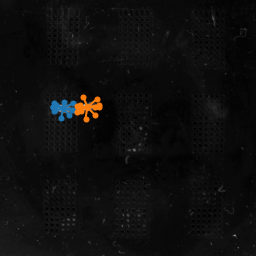

In [38]:
# Visualize a frame.
#predictions[100].plot(scale=0.25)

#!python -c "import sleap; video = sleap.load_video('video.mp4'); imgs = video[:100]; print(f'imgs.shape: {imgs.shape}'); predictor = sleap.load_model(['centroid_model.zip', 'centered_instance_id_model.zip'], batch_size=16); predictions=predictor.predict(imgs); print(predictions); predictions.save('IRF_pred.slp')"
!python -c "import sleap; import matplotlib.pyplot as plt; predictions = sleap.load_file('IRF_pred.slp'); predictions[100].plot(scale=0.25); plt.savefig('predictions_100.png')"

from IPython.display import Image
Image('predictions_100.png')

In [39]:
# Inspect the contents of a single frame.
#labeled_frame = predictions[100]
#labeled_frame.instances

!python -c "import sleap; predictions = sleap.load_file('IRF_pred.slp'); labeled_frame=predictions[100]; print(labeled_frame.instances)"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
[PredictedInstance(video=Video(filename=video.mp4, shape=(2560, 1024, 1024, 1), backend=MediaVideo), frame_idx=100, points=[head: (212.5, 427.0, 0.94), thorax: (252.0, 433.1, 0.95), abdomen: (288.6, 439.3, 0.68), wingL: (304.5, 443.3, 0.88), wingR: (306.2, 435.8, 0.68), forelegL4: (216.2, 445.5, 0.88), forelegR4: (216.1, 410.0, 0.90), midlegL4: (244.4, 471.3, 0.90), midlegR4: (256.6, 408.9, 0.86), hindlegL4: (275.0, 459.2, 0.89), hindlegR4: (292.3, 412.0, 0.81), eyeL: (220.0, 438.0, 0.84), eyeR: (223.8, 417.5, 0.91)], score=1.01, track=Tr

In [41]:
# Convert an instance to a numpy array:
#labeled_frame[0].numpy()

!python -c "import sleap; predictions = sleap.load_file('IRF_pred.slp'); labeled_frame=predictions[100]; print(labeled_frame[0].numpy())"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
[[212.51400757 426.97024536]
 [251.97747803 433.08648682]
 [288.64355469 439.3086853 ]
 [304.53396606 443.33477783]
 [306.20336914 435.77227783]
 [216.24688721 445.4755249 ]
 [216.14550781 409.98342896]
 [244.39497375 471.31561279]
 [256.61740112 408.89056396]
 [274.97470093 459.1831665 ]
 [292.2600708  411.95904541]
 [219.98565674 437.97906494]
 [223.75567627 417.5496521 ]]


What if we don't want or need the inference results wrapped in the SLEAP structures?

By using the low-level inference model, we can actually go directly from image to numpy arrays of our results:

In [47]:
#imgs = video[:16]  # batch of 16 images
#predictor = sleap.load_model(["centroid_model.zip", "centered_instance_id_model.zip"], batch_size=16)
#predictions = predictor.inference_model.predict(imgs, numpy=True)
#predictions

#!python -c "import sleap; predictions = sleap.load_file('IRF_pred.slp'); labeled_frame=predictions[100]; print(labeled_frame[0].numpy())"
!python -c "import sleap; video = sleap.load_video('video.mp4'); imgs = video[:16]; predictor=sleap.load_model(['centroid_model.zip', 'centered_instance_id_model.zip'], batch_size=16); predictions = predictor.inference_model.predict(imgs, numpy=True); print(predictions)"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
2025-04-20 21:11:13.104580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 21:11:13.194361: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 21:11:13.194786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to 

In [48]:
#for key, value in predictions.items():
#    print(f"'{key}': {value.shape} ({value.dtype})")

!python -c "import sleap; video = sleap.load_video('video.mp4'); imgs = video[:16]; predictor=sleap.load_model(['centroid_model.zip', 'centered_instance_id_model.zip'], batch_size=16); predictions = predictor.inference_model.predict(imgs, numpy=True); [print(f'{key}: {value.shape} ({value.dtype})')for key, value in predictions.items()]"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
2025-04-20 21:14:52.214402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 21:14:52.299827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 21:14:52.300256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to 

## 4. Realtime performance

Now that we know how to do inference with different types of outputs, let's try to use that to build a simulated "realtime" application with timing.

First, we'll create a class that simulates a camera grabber API that provides a sequence of pre-loaded frames.

In [55]:
from time import perf_counter
import numpy as np

# a set of 5 frames in frames = [frame1, frame2, frame3, frame4, frame5].
# call grab_frame(), it will return frame1 on the first call, frame2 on the second, and so on.
# After reaching frame5, on the next call, it will loop back and return frame1 again, bc the frame index is wrapped around using the modulo operation.
class SimulatedCamera:
    """Simulated camera class that serves frames from memory continuously.

    Attributes:
        frames: Numpy array with pre-loaded frames.
        frame_counter: Count of frames that have been grabbed.
    """

    frames: np.ndarray
    frame_counter: int

    def __init__(self, frames):
        self.frames = frames
        self.frame_counter = 0

    def grab_frame(self):
        idx = self.frame_counter % len(self.frames)
        self.frame_counter += 1
        return self.frames[idx]


In [115]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [134]:
!python -c "exec(open('/content/drive/My Drive/sleap/script.py').read())"

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
Loading saved model...
/usr/local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
Starting inference loop...
2025-04-20 22:44:37.988045: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -64 } dim { size: -65 } dim { size: -66 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -2 } dim { size: 4 } } } inputs { dtype: DT_INT32 sha

Then, we'll define a simply acquisition loop, in which we repeatedly grab a frame and perform inference to time how long it takes.

In [ ]:
# load video and model
print("Loading saved model...")
vid = sleap.load_video('video.mp4')
predictor = sleap.load_model(['centroid_model.zip', 'centered_instance_id_model.zip'], batch_size=16)

recording_duration = 100  # session length in frames

# Pre-load images onto "camera"
camera = SimulatedCamera(vid[:512])

# Camera capture loop
inference_times = []
frames_recorded = 0
while frames_recorded < recording_duration:
    # Get the next frame.
    frame = camera.grab_frame()
    frames_recorded += 1

    # Get inference results for the frame and time how long it took.
    t0 = perf_counter()
    frame_predictions = predictor.inference_model.predict_on_batch(np.expand_dims(frame, axis=0))
    dt = perf_counter() - t0
    inference_times.append(dt)

# Convert to milliseconds.
inference_times = np.array(inference_times) * 1000

# Separate out first timing from the rest. The first inference call is much slower as it builds the compute graph.
first_inference_time, inference_times = inference_times[0], inference_times[1:]
print(f"First inference time: {first_inference_time:.1f} ms")
print(f"Inference times: {inference_times.mean():.1f} +- {inference_times.std():.1f} ms")

In [138]:
inference_times = [
    20.86335, 19.96043, 20.290406, 19.440166, 19.48017, 19.905561, 19.395166,
    20.255643, 25.119998, 20.357815, 20.546457, 20.338786, 19.858538, 19.9662,
    21.925661, 33.30501, 21.115322, 19.807258, 19.496991, 19.46515, 20.142293,
    19.257864, 23.308372, 20.191637, 20.35637, 19.884765, 19.230213, 19.668031,
    19.563682, 19.552381, 19.597656, 19.122233, 19.531453, 18.958498, 19.682181,
    19.049104, 19.048408, 19.114361, 19.745579, 20.502218, 19.39621, 19.43212,
    22.775919, 19.64606, 20.171144, 20.944253, 19.978113, 21.64599, 19.961756,
    19.801463, 19.943157, 19.471687, 21.266067, 24.758787, 20.758341, 21.156254,
    19.827208, 19.583581, 20.016125, 19.233687, 19.877774, 20.066659, 20.528812,
    19.816535, 19.809986, 28.367984, 28.816024, 20.276119, 20.239169, 20.206572,
    20.786588, 25.224335, 21.231127, 22.079323, 21.809592, 20.895032, 20.368061,
    21.34412, 21.148268, 20.214345, 22.183037, 20.986139, 20.350835, 19.818162,
    20.295797, 21.049181, 22.368031, 21.616739, 20.490757, 23.06716, 21.196408,
    19.71463, 20.459016, 20.322055, 20.222261, 21.308499, 21.146886, 20.353367,
    20.294443
]


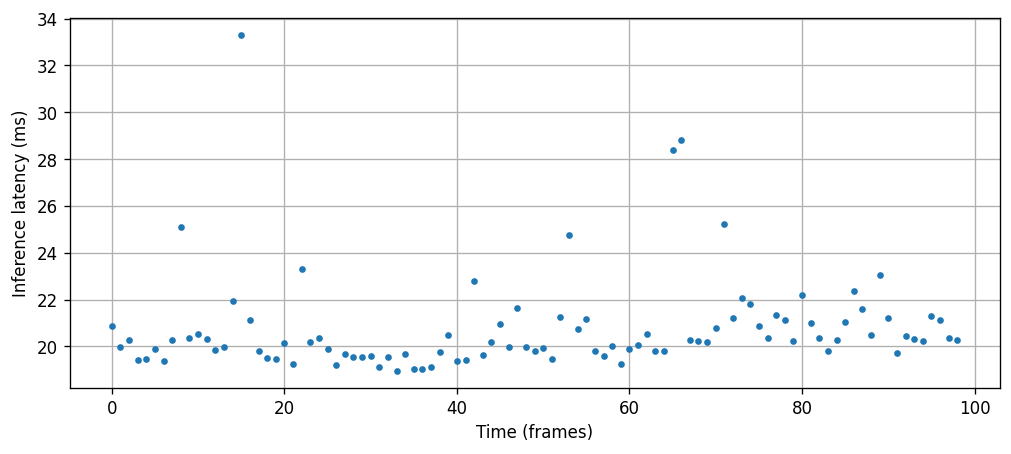

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4), dpi=120, facecolor="w")
plt.plot(inference_times, ".")
plt.xlabel("Time (frames)")
plt.ylabel("Inference latency (ms)")
plt.grid(True);

After the first batch, our inference latencies go way down and we can see how they vary over time:

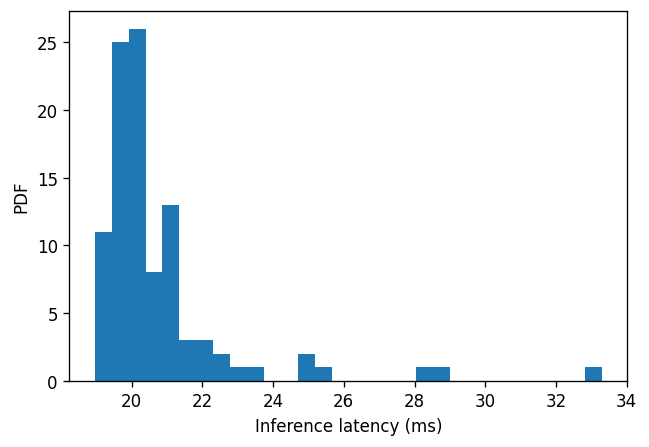

In [141]:
plt.figure(figsize=(6, 4), dpi=120, facecolor="w")
plt.hist(inference_times, bins=30)
plt.xlabel("Inference latency (ms)")
plt.ylabel("PDF");